# Pima Indians Diabetes Classification - Toby Liang

## Importing Essential Libraries

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

## Data Summary

In [2]:
# Load dataset
dataset = pd.read_csv("./data/diabetes.csv")

# Feature renaming
dataset.columns = ["pregnancies", "glucose", "blood_pressure", "skin_thickness", "insulin", "body_mass_index", "pedigree", "age", "label"]

# Get first 5 examples
dataset.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,body_mass_index,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


All features are quantitative so no one-hot encoding is required.  The data, however, is not normalized or standardized so some preprocessing will need to be done.  Features such as insulin and skin thickness have 0 values which does not make sense.

### Check for NaN Values

In [3]:
# Check for NaN values
dataset.isnull().sum()

pregnancies        0
glucose            0
blood_pressure     0
skin_thickness     0
insulin            0
body_mass_index    0
pedigree           0
age                0
label              0
dtype: int64

Data does not contain any NaN values.

### Check for 0 Values

In [4]:
# Check for 0 values
(dataset == 0).astype(int).sum()

pregnancies        111
glucose              5
blood_pressure      35
skin_thickness     227
insulin            374
body_mass_index     11
pedigree             0
age                  0
label              500
dtype: int64

Data contains 0 values for features that can not be 0 such as glucose, blood pressure, skin thickness, insulin, and body mass index.  These 0 values will be replaced by the mean.

### Check for Duplicates

In [5]:
# Check for duplicate values
dataset.duplicated().value_counts()

False    768
dtype: int64

### Get Unique Labels

In [6]:
dataset.label.unique()

array([1, 0])

Labels are binary so this is a binary classification problem.  (0 meaning no diabetes and 1 meaning diabetes)

## Data Preprocessing

In [7]:
from sklearn.preprocessing import scale

In [8]:
# Replace zeros with means
non_zero_cols = ["glucose", "blood_pressure", "skin_thickness", "insulin", "body_mass_index"]
for col in non_zero_cols:
    mean = dataset[col].mean()
    dataset[col].mask(dataset[col] == 0, mean, inplace=True)
    
# Zero replace sanity check
print((dataset == 0).astype(int).sum())
    
# Feature-label splitting
features = dataset.drop("label", axis=1)
labels = dataset[["label"]]

# Data standardization
features[features.columns] = scale(features[features.columns])

# Data summary
features.describe().T.round(2)

pregnancies        111
glucose              0
blood_pressure       0
skin_thickness       0
insulin              0
body_mass_index      0
pedigree             0
age                  0
label              500
dtype: int64


,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,-0.0,1.0,-1.14,-0.84,-0.25,0.64,3.91
glucose,768.0,-0.0,1.0,-2.55,-0.72,-0.15,0.61,2.54
blood_pressure,768.0,0.0,1.0,-3.99,-0.68,-0.02,0.64,4.11
skin_thickness,768.0,0.0,1.0,-2.04,-0.63,-0.37,0.56,7.52
insulin,768.0,-0.0,1.0,-1.13,-0.42,-0.42,0.09,7.82
body_mass_index,768.0,-0.0,1.0,-2.07,-0.72,-0.07,0.60,5.04
pedigree,768.0,0.0,1.0,-1.19,-0.69,-0.30,0.47,5.88
age,768.0,0.0,1.0,-1.04,-0.79,-0.36,0.66,4.06


## Exploratory Data Analysis

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

### Label Counts

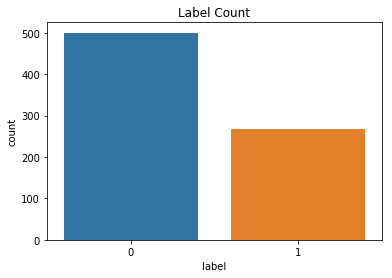

In [10]:
# Label count
plt.title("Label Count")
sns.countplot(labels.label)
plt.show()

There are significantly more subjects without diabetes than with diabetes as shown above.

### Feature-Label Correlation

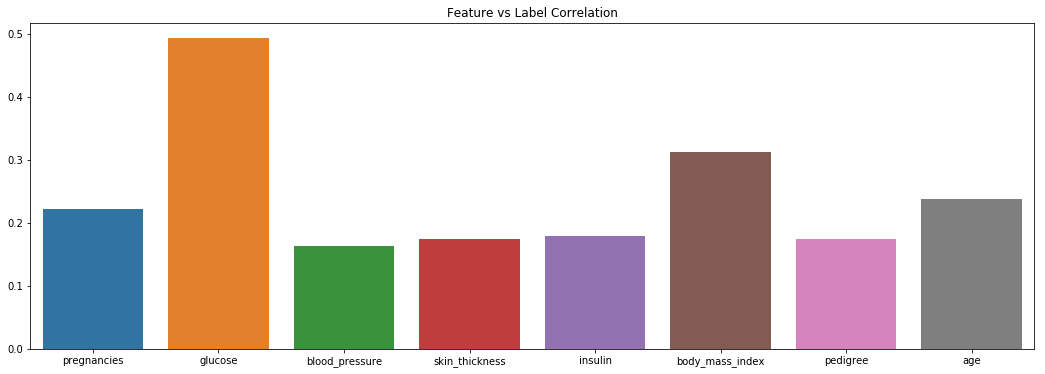

In [11]:
# Getting feature-label correlation
correlation = dataset.corr()
label_correlation = correlation["label"]
label_correlation.drop("label", inplace=True)

# Plot
plt.figure(figsize=(18, 6))
plt.title("Feature vs Label Correlation")
sns.barplot(label_correlation.index, label_correlation.values)
plt.show()

Glucose amount has the greatest correlation with diabetes with a value close to 0.5.  Body mass index also has a fairly high correlation while most other features have a correlation between 0.15 and 0.3.

### Feature Distributions

[]

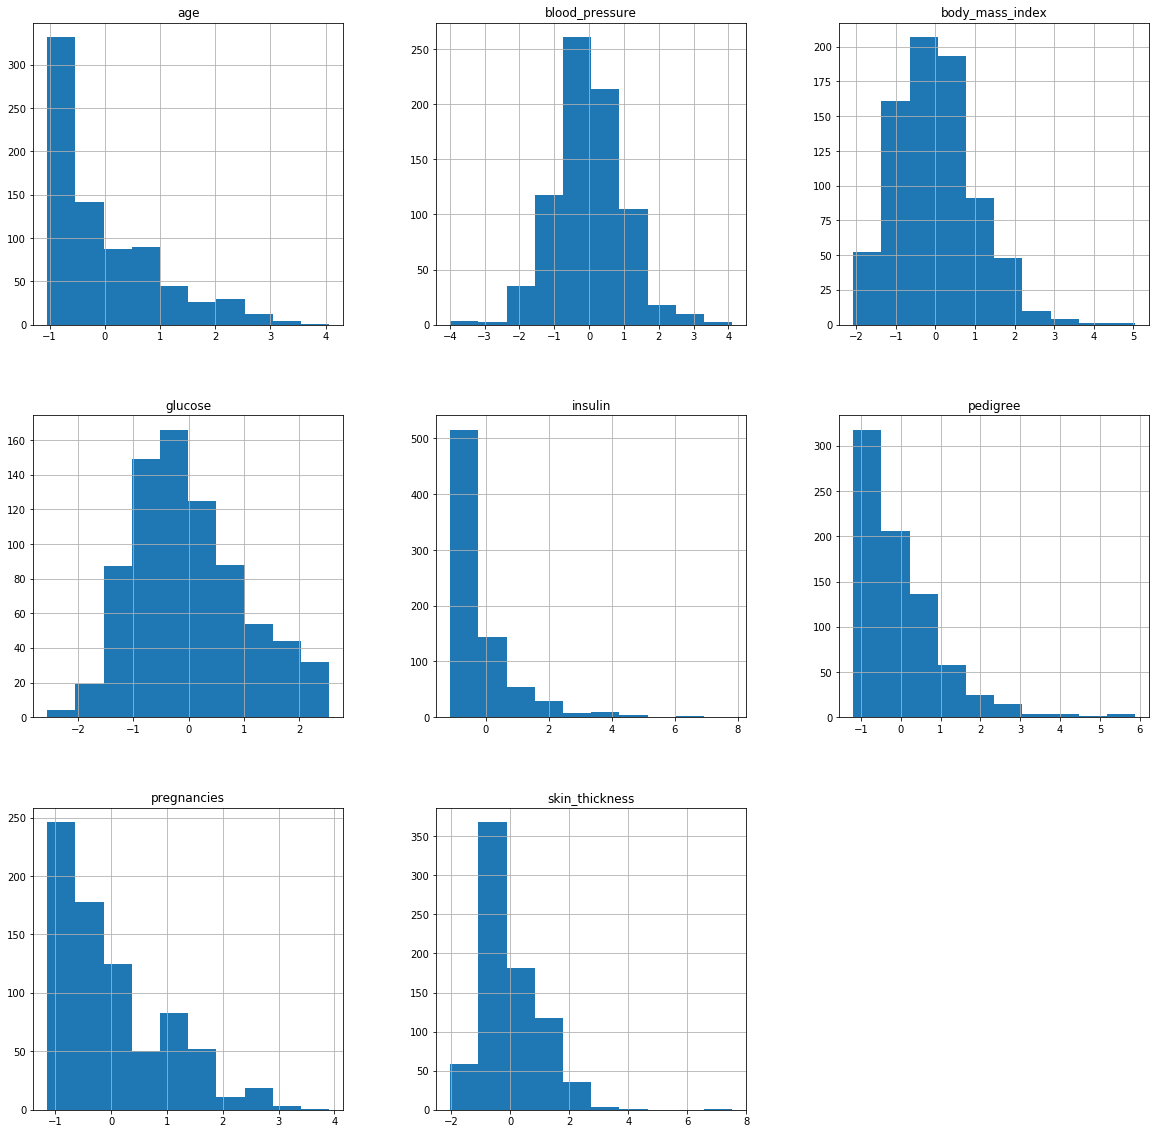

In [12]:
# Visualizing feature distributions
features.hist(figsize=(20,20))
plt.plot()

Every feature is right skewed (mean > median) with the most skewed being insulin, skin thickness, and age.

## Models

### Utility functions

In [13]:
from sklearn.model_selection import train_test_split

def split_data():
    return train_test_split(features, labels, train_size=0.8)

def avg_acc(function, iterations):
    sum = 0.0
    for i in range(iterations):
         sum += function()
    print("Avg Accuracy: {}".format(sum / iterations))

### Support Vector Machine

In [14]:
from sklearn.svm import SVC

In [15]:
def train_svm():
    # Split data
    train_data, test_data, train_labels, test_labels = split_data()
    
    # Initialize and fit model
    model = SVC()
    model.fit(train_data, train_labels)
    
    # Return accuracy
    return model.score(test_data, test_labels)

In [16]:
avg_acc(train_svm, iterations=100)

Avg Accuracy: 0.7614285714285712


### Neural Network

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [29]:
class Model():
    def __init__(self, hyperparams):
        default = {"lr": 0.005}
        self.hyperparams = hyperparams if hyperparams != None else default
        self.model = self.create_model()
        self.history = None
        
    def create_model(self, lr=0.005):
        model = Sequential()
        model.add(Dense(10, activation="relu", kernel_regularizer=l2(0.025)))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer=Adam(lr=self.hyperparams["lr"]), metrics=["accuracy"])
        
        return model
        
    def fit(self, train_data, train_labels):
        history = self.model.fit(train_data.values, train_labels.values, 
                                 epochs=50, validation_split=0.2, verbose=0)
        self.history = history
        return history        
    
    def plot_acc(self):
        if (self.history != None):
            figure, (loss, acc) = plt.subplots(1, 2, figsize=(15,8))
            loss.set_title("Loss")
            loss.plot(self.history.history["loss"])
            loss.plot(self.history.history["val_loss"])

            acc.set_title("Accuracy")
            acc.plot(self.history.history["acc"])
            acc.plot(self.history.history["val_acc"])
            plt.show()
            
            print("Val Accuracy: " + str(self.history.history["val_acc"][-1]))
            print("Accuracy: " + str(self.history.history["acc"][-1]) + "\n")
            print("Loss: " + str(self.history.history["loss"][-1]))
            print("Val Loss: " + str(self.history.history["val_loss"][-1]))
        else:
            print("Model not fitted...")
        
    def score(self, test_data, test_labels):
        return self.model.evaluate(test_data, test_labels, verbose=0)[1]

In [43]:
def train_nn():
    # Split data
    train_data, test_data, train_labels, test_labels = split_data()
    
    # Initialize and fit model
    model = Model()
    model.fit(train_data, train_labels)
    
    # Return accuracy
    return model.score(test_data, test_labels)

def plot_nn():
    # Split data
    train_data, test_data, train_labels, test_labels = split_data()
    
    # Initialize and fit model
    model = Model()
    model.fit(train_data, train_labels)
    
    # Plot acc
    model.plot_acc()
    
def tune_nn():
    # Split data
    train_data, test_data, train_labels, test_labels = split_data()
    model = Model()
    tuner = KerasClassifier(build_fn=model.create_model)
    lr = [0.1, 0.3]
    hyperparams = {"lr": lr}
    random_search = RandomizedSearchCV(estimator=tuner, n_iter=5, param_distributions=hyperparams)
    random_search.fit(train_data, train_labels)

In [44]:
tune_nn()

ValueError: lr is not a legal parameter

In [21]:
avg_acc(train_nn, iterations=5)

Avg Accuracy: 0.7571428569880398
